In [1]:
import numpy as np

from Code.Tutorial.algo_ssa import SSA
from Code.Tutorial.Dataset import load_scg
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pylab as plt
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

In [2]:
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

def get_peaks(data_tmp, distance, duration, sampling_rate):
    data_tmp = data_tmp / np.max(data_tmp)

    t = np.linspace(0, duration, duration * sampling_rate)
    signal = data_tmp

    peak_indices, _ = find_peaks(signal)

    t_peaks = t[peak_indices]
    peak_values = signal[peak_indices]
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2, _ = find_peaks(envelope,distance=distance)

    peaks2 = update_array(peaks2, data_tmp)
    if len(peaks2) % 2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)

    return peaks2

In [3]:
def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    threshold = 1
    filtered_a = a[np.abs(a - mean) <= threshold * std]

    return filtered_a

def get_mag_0(peaks2, data_tmp):
    mag = data_tmp[peaks2[::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_mag_1(peaks2, data_tmp):
    mag = data_tmp[peaks2[1::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_features(data_tmp, peaks2):
    maxm = np.max(data_tmp)
    data_tmp_raw = data_tmp
    data_tmp = data_tmp / maxm

    data_tmp = data_tmp_raw / maxm

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]
    diff_22 = peaks2[2::2] - peaks2[:-2:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)
    diff_22 = delete_unique(diff_22)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)
    m_22 = np.mean(diff_22)

    # mag_0 = get_mag_0(peaks2, data_tmp_raw)
    # mag_1 = get_mag_1(peaks2, data_tmp_raw)
    mag_1 = get_mag_1(peaks2, data_tmp)
    mag_0 = get_mag_0(peaks2, data_tmp)

    features = np.array([m_12, m_21, m_22, m_12 / m_21, mag_0, mag_1, mag_0 - mag_1, mag_0 / mag_1])

    return features

In [4]:
def features_indexes(signals, L, trend2period, distance, show ):

    sampling_rate = fs
    idx = []
    features = []
    for i in tqdm(range(len(signals))):
        signal = signals[i]
        ssa_ = SSA(signal, L)
        ssa_signal = ssa_.reconstruct(slice(trend2period[i], L))
        peaks = get_peaks(ssa_signal, distance, duration, sampling_rate)

        idx.append(i)

        if show:
            # ssa_.calc_wcorr()
            ssa_.plot_wcorr(0, 35)
            plt.show()

            plt.subplots(3, 1, figsize=(20, 12))
            plt.subplot(3, 1, 1)
            ssa_.orig_TS.plot(alpha=0.3, label='Noisy Signal')
            ssa_.reconstruct(slice(0, trend2period[i])).plot(label='Noise Trend')
            plt.title('Noisy Signal and its Trend')
            plt.legend()
            plt.subplot(3, 1, 2)
            ssa_.orig_TS.plot(alpha=0.3, label='Noisy Signal')
            ssa_.reconstruct(slice(trend2period[i], L)).plot(label='Reconstructed Signal')
            plt.title('Noisy Signal and Reconstructed Signal')
            plt.legend()
            plt.subplot(3, 1, 3)
            plt.plot(signals_clean_idxed[i], label='Clean Signal')
            ssa_.reconstruct(slice(trend2period[i], L)).plot(label='Reconstructed Signal')
            plt.title('Clean Signal and Reconstructed Signal')
            plt.legend()
            plt.show()

        features.append(get_features(ssa_signal, peaks))
        if i >= 30:
            break
    return features, idx



In [5]:
if __name__ == '__main__':
    signals_train, labels_train, duration, fs = load_scg(0.8, 'train')
    signals_test, labels_test, _, _ = load_scg(0.8, 'test')
    signals_clean, _, _, _ = load_scg(0, 'train')
    S_train, D_train = labels_train[:, -2], labels_train[:, -1]
    S_test, D_test = labels_test[:, -2], labels_test[:, -1]

    features_train_np = np.load('../../Data/SSA/features_train_0.8_5000.npz.npy')
    features_test_np = np.load('../../Data/SSA/features_test_0.8_3000.npz.npy')
    idx_train = np.load('../../Data/SSA/idx_train_0.8_5000.npz.npy')
    idx_test = np.load('../../Data/SSA/idx_test_0.8_3000.npz.npy')

    L = 100
    trend2period = 10

    signals_train_idxed = signals_train[idx_train]
    labels_train_idxed = labels_train[idx_train]

    signals_test_idxed = signals_test[idx_test]
    labels_test_idxed = labels_test[idx_test]
    signals_clean_idxed = signals_train[idx_train]
    S_train_idxed = S_train[idx_train]
    D_train_idxed = D_train[idx_train]
    S_test_idxed = S_test[idx_test]
    D_test_idxed = D_test[idx_test]
    HR_train_idxed = labels_train[idx_train, 2]
    HR_test_idxed = labels_test[idx_test, 2]
    print(HR_test_idxed.shape, HR_test_idxed)

(2812,) [ 67. 122. 147. ...  91.  68.  95.]


features_emp:0.47877145438121044, features_manual:0.47877145438121044


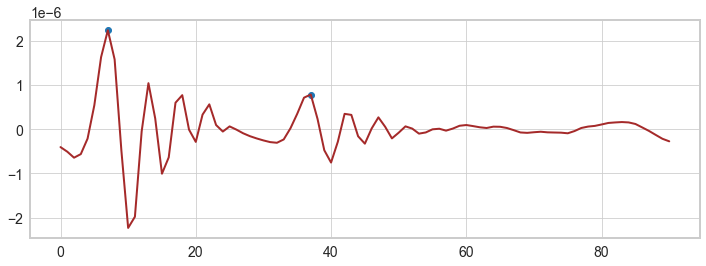

template d12/d21:0.4918032786885246
features_emp:0.7241379310344828, features_manual:0.7241379310344828


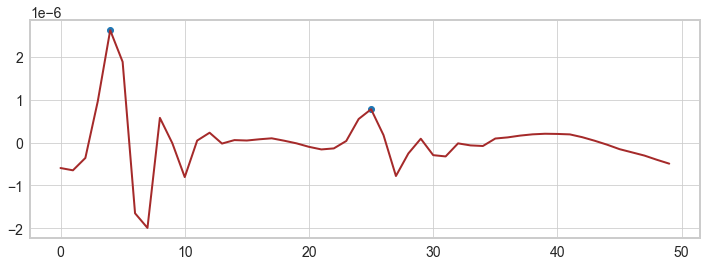

template d12/d21:0.7241379310344828
features_emp:0.5, features_manual:0.5


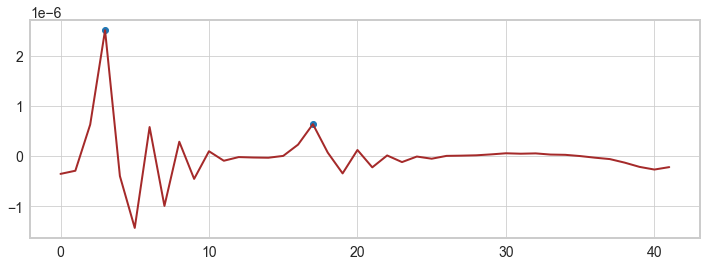

template d12/d21:0.5
features_emp:0.7531096871466264, features_manual:0.7488721804511278


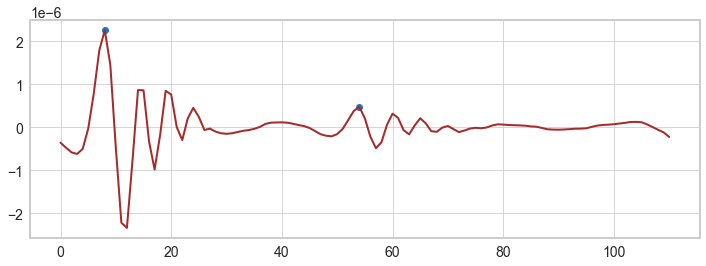

template d12/d21:0.7076923076923077
features_emp:0.4870757868823633, features_manual:0.4847639484978541


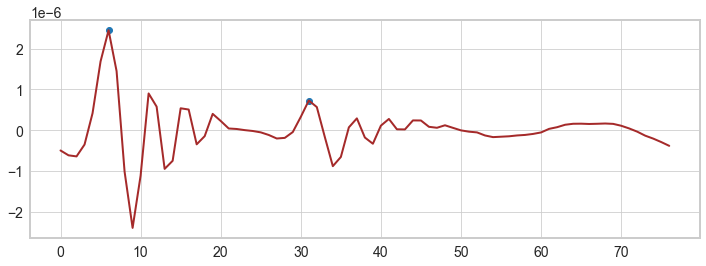

template d12/d21:0.4807692307692308
features_emp:0.6949152542372882, features_manual:0.6949152542372882


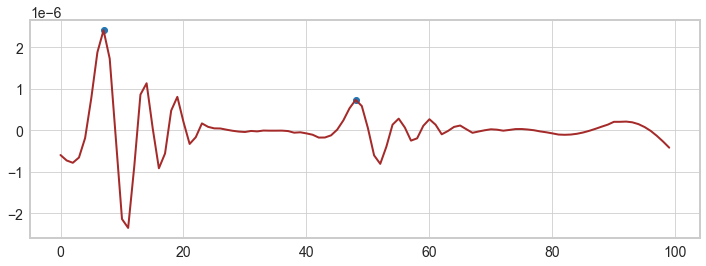

template d12/d21:0.6949152542372882
features_emp:0.6497524752475248, features_manual:0.6475366876310273


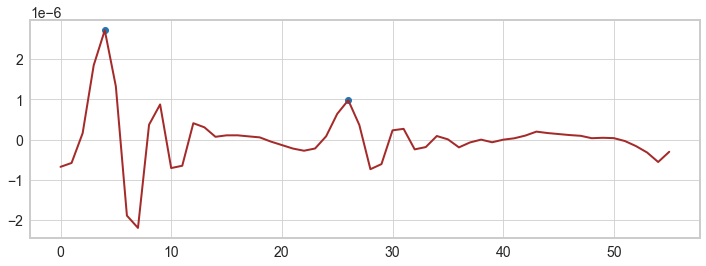

template d12/d21:0.6470588235294118
features_emp:0.5769230769230769, features_manual:0.5769230769230769


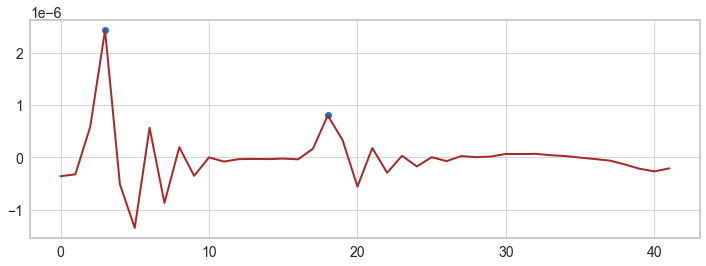

template d12/d21:0.5555555555555556
features_emp:0.7352941176470589, features_manual:0.7352941176470589


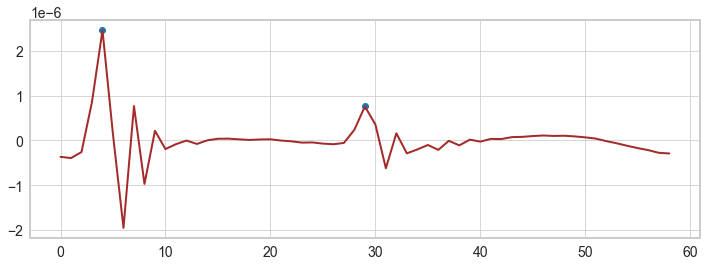

template d12/d21:0.7352941176470589
features_emp:0.44084278768233387, features_manual:0.4358974358974359


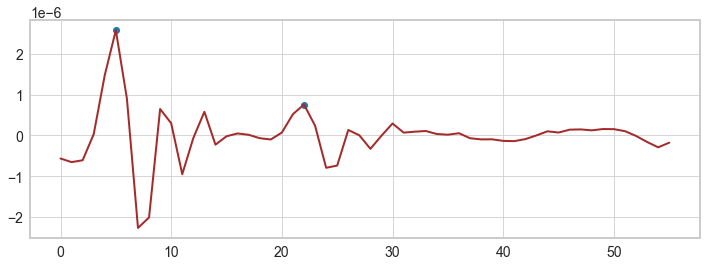

template d12/d21:0.4358974358974359
features_emp:0.4375, features_manual:0.4375


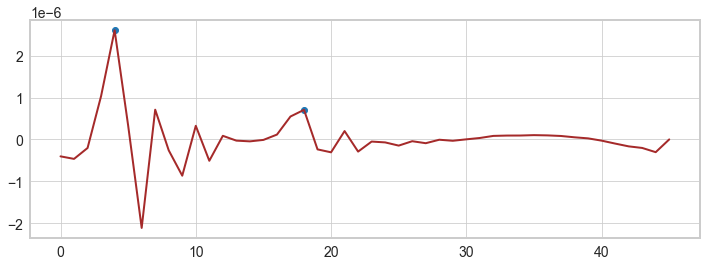

template d12/d21:0.4375
features_emp:0.43831168831168826, features_manual:0.43831168831168826


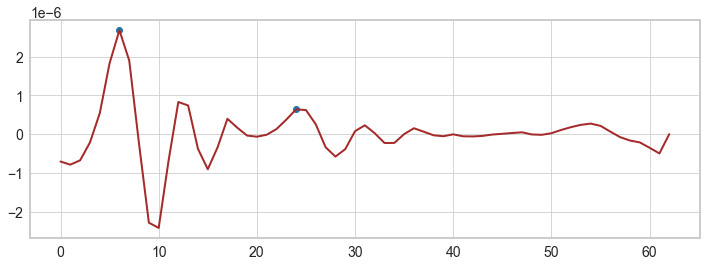

template d12/d21:0.4
features_emp:0.5434843400447428, features_manual:0.5384615384615384


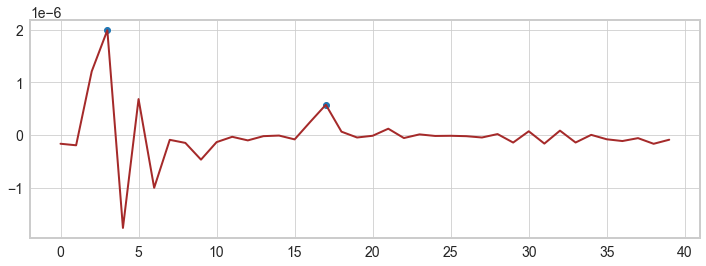

template d12/d21:0.5384615384615384
features_emp:0.699679724069968, features_manual:0.6767471879033746


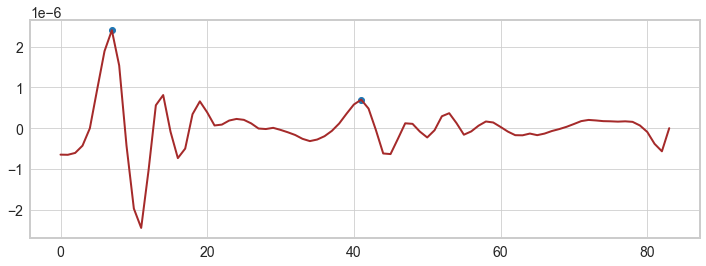

template d12/d21:0.68
features_emp:0.5334429824561404, features_manual:0.5334429824561404


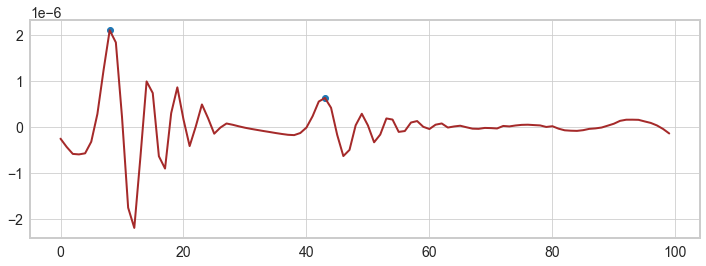

template d12/d21:0.5384615384615384
features_emp:1.8750000000000002, features_manual:0.5753715498938429


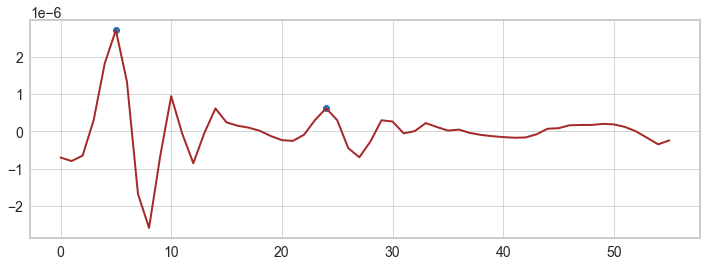

template d12/d21:0.5135135135135135
features_emp:0.6025641025641025, features_manual:0.6025641025641025


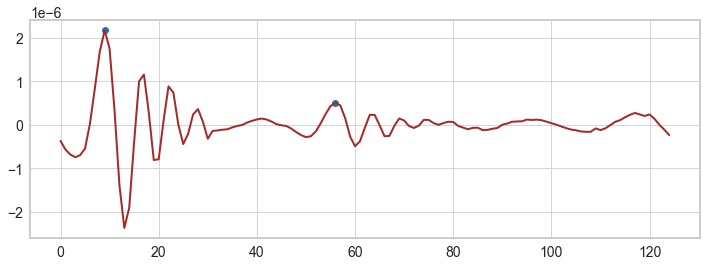

template d12/d21:0.6025641025641025
features_emp:0.6388888888888888, features_manual:0.6388888888888888


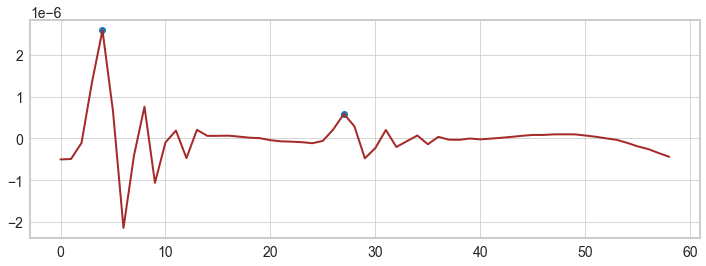

template d12/d21:0.6388888888888888
features_emp:0.7777777777777778, features_manual:0.7777777777777778


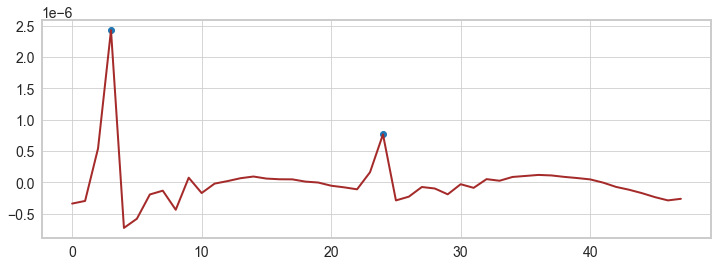

template d12/d21:0.7777777777777778
features_emp:0.5, features_manual:0.5


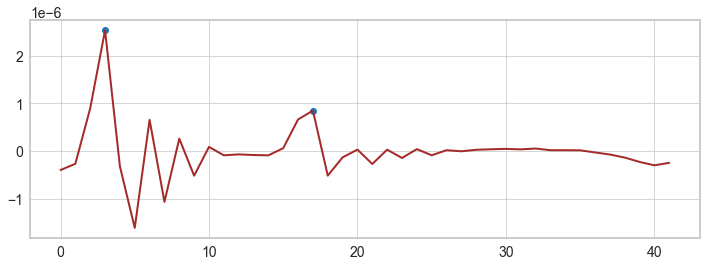

template d12/d21:0.5
features_emp:0.5555555555555556, features_manual:0.5555555555555556


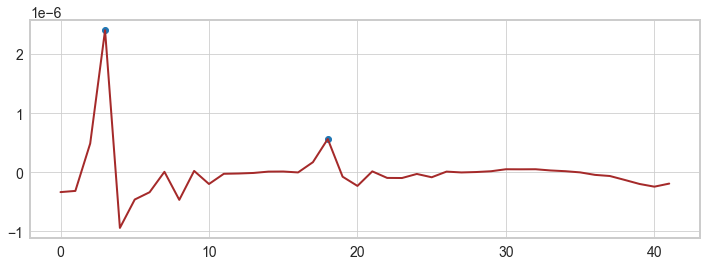

template d12/d21:0.5555555555555556
features_emp:0.7361111111111112, features_manual:0.7729166666666667


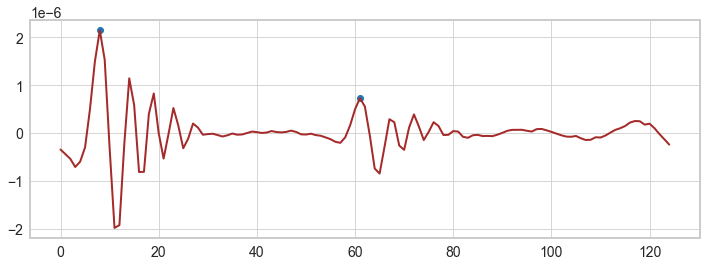

template d12/d21:0.7361111111111112
features_emp:0.6296296296296297, features_manual:0.6296296296296297


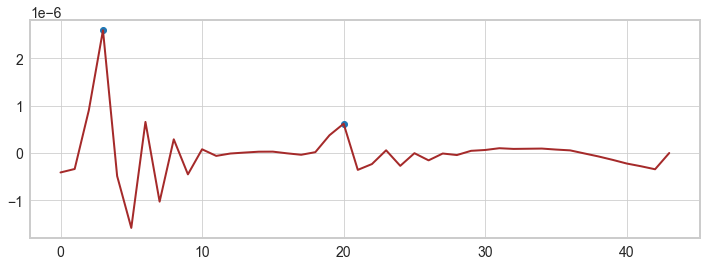

template d12/d21:0.6296296296296297
features_emp:0.7134902958956411, features_manual:0.5132022471910113


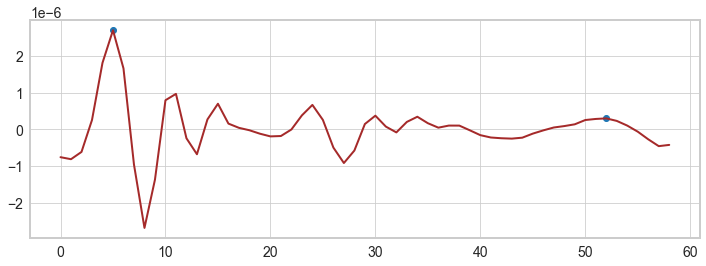

template d12/d21:3.9166666666666665
features_emp:0.5424063116370809, features_manual:0.5424063116370809


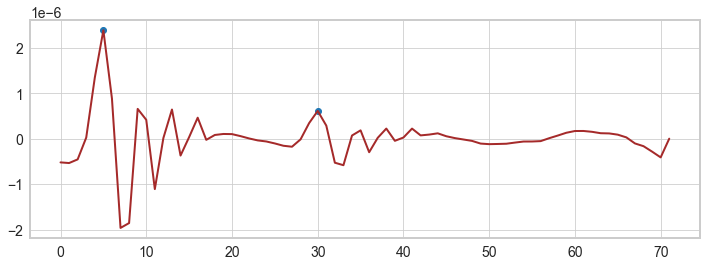

template d12/d21:0.5319148936170213
features_emp:0.4827586206896552, features_manual:0.4827586206896552


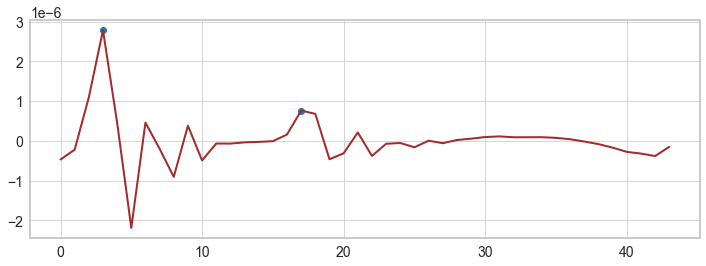

template d12/d21:0.4666666666666667
features_emp:0.7736720554272518, features_manual:0.8409586056644881


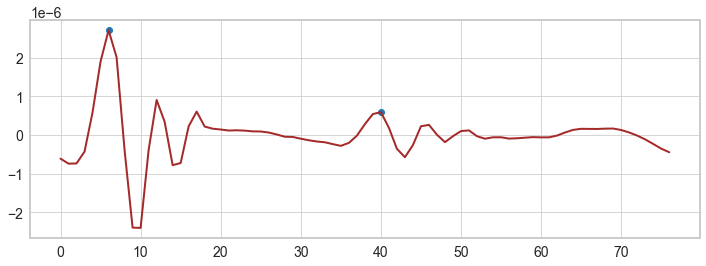

template d12/d21:0.7906976744186046
features_emp:0.5151515151515151, features_manual:0.5151515151515151


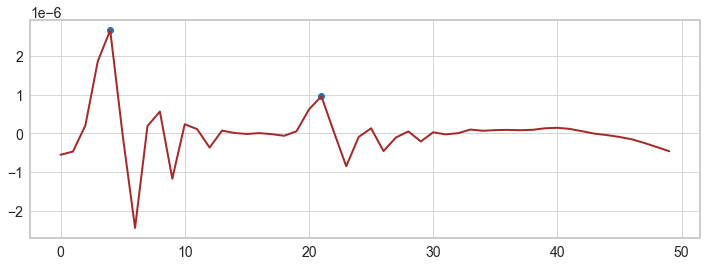

template d12/d21:0.5151515151515151
features_emp:0.639344262295082, features_manual:0.6294784580498867


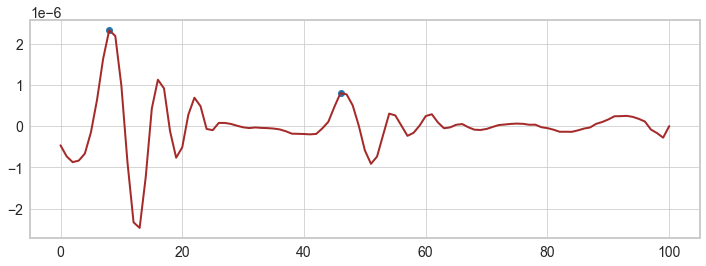

template d12/d21:0.6031746031746031
features_emp:2.0689655172413794, features_manual:2.0689655172413794


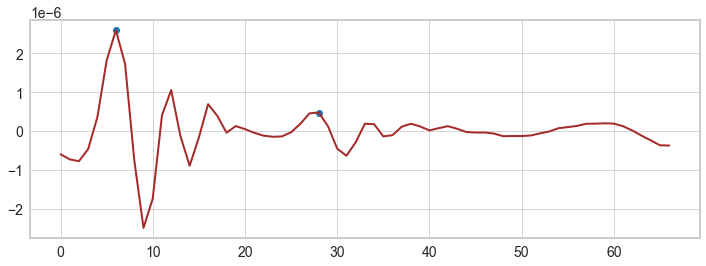

template d12/d21:0.4888888888888889


In [43]:
def segmentation(signal, rpeak):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])

    # plt.figure(figsize=(12, 4))

    Nmax = 0
    for piece in pieces:
        Nmax = max(Nmax, piece.shape[0])
        # plt.plot(piece, alpha = 0.2, color='gray', linewidth=1.5 )

    pieces_padded = []
    for piece in pieces:
        N = Nmax - piece.shape[0]
        pieces_padded.append(np.pad(piece, (0, N), 'constant'))
    pieces_padded = np.array(pieces_padded)

    template = np.median(pieces_padded, 0)
    # plt.plot(template, label='Median',color='brown', linewidth=2)

    template_peaks_ = get_peaks(template, 10, duration, fs)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        pass

    # plt.scatter(template_peaks, template[template_peaks])
    # plt.show()
    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    print(f'template d12/d21:{dis12/dis21}')

trend2period_test = [10, 10, 10, 9, 9, 10, 6, 10, 11, 11, 10, 10, 9, 9, 10, 6, 11, 11, 11, 10, 10, 12, 11, 6, 10, 10, 9, 10, 11, 10, 11]
L = 100
for i in range(30):
    signal = signals_test_idxed[i]

    # print(i, labels_test_idxed[i, 2:])
    manual_point = trend2period_test[i]
    emp_point = 10

    # if abs(manual_point - emp_point) > 0:
    ssa_ = SSA(signal, L)
    #
    # print(f'id:{i}, emp_point:{emp_point}, manual_point:{manual_point}')
    #
    # ssa_.plot_wcorr(0, 50)
    # plt.show()
    #
    # plt.subplots(3, 1, figsize=(20, 8))
    # plt.subplot(3, 1, 1)
    # ssa_.reconstruct(slice(0, emp_point)).plot(label='Emp Trend')
    # ssa_.reconstruct(slice(0, manual_point)).plot(label='Manual Trend')
    # ssa_.orig_TS.plot(alpha=0.3, label='Noisy Signal')
    # plt.title('Noisy Signal and its Trend')
    # plt.legend()
    # plt.subplot(3, 1, 2)
    # # ssa_.orig_TS.plot(alpha=0.3, label='Noisy Signal')
    signal_emp = ssa_.reconstruct(slice(emp_point, L))
    signal_manual = ssa_.reconstruct(slice(manual_point, L))
    # signal_emp.plot(label='Emp Signal')
    # signal_manual.plot(label='Manual Signal')
    #
    peaks_emp = get_peaks(signal_emp, 10, duration, fs)
    peaks_manual = get_peaks(signal_manual, 10, duration, fs)
    features_emp = get_features(signal_emp, peaks_emp)[3]
    features_manual = get_features(signal_manual, peaks_manual)[3]
    #
    print(f'features_emp:{features_emp}, features_manual:{features_manual}')
    # plt.scatter(peaks_emp, signal_emp[peaks_emp], label='emp')
    # plt.scatter(peaks_manual, signal_manual[peaks_manual], label='manual')
    # plt.title('Noisy Signal and its Signal')
    # plt.legend()
    #
    # plt.subplot(3, 1, 3)
    # large_peaks, _ = find_peaks(signal_manual, height=np.max(signal_manual) * 0.3, distance=int(6000//(HR_test_ided[i]+2)))
    # print(large_peaks)
    # plt.plot(signal_manual, label='Signal Manual')
    # plt.scatter(large_peaks, signal_manual[large_peaks], label='large peaks manual')
    # plt.legend()
    # plt.show()

    signal_emp = ssa_.reconstruct(slice(emp_point, L))
    large_peaks, _ = find_peaks(signal_emp, height=np.max(signal_emp) * 0.3, distance=int(6000//(HR_test_ided[i]+2)))

    segmentation(signal_emp, large_peaks)
        # break

In [75]:
X, y = features_train_np[:, 3].reshape(-1, 1), S_train[idx_train]
X_inacc, y_inacc = features_train_30_np[:, 3].reshape(-1, 1), S_train[idx_30_train_np]

plt.figure()
idx_start, idx_end = 0, 31
plt.scatter(X[31:], y[31:], label='train 31:')
plt.scatter(X[:31], y[:31], label='train :31', marker='x')
plt.scatter(X_inacc[idx_start: idx_end], y_inacc[idx_start: idx_end], label='inaccurate train :31')
plt.legend()
plt.show()

SyntaxError: invalid syntax (4288959118.py, line 1)

In [6]:
# X, y = features_train_np[:, 3].reshape(-1, 1), S_train[idx_train]
# X_test, y_test = features_test_np[:, 3], S_test[idx_test]
# X_acc, y_acc = features_train_30_np[:, 3].reshape(-1, 1), S_train[idx_30_train_np]
# X_test_acc, y_test_acc = features_test_30_np[:, 3].reshape(-1, 1), S_test[idx_30_test_np]
# plt.figure()
# idxex_start, idxex_end = 0, 8
# plt.scatter(X[31:], y[31:], label='train 31:')
# plt.scatter(X[:31], y[:31], label='train :31', marker='x')
# plt.scatter(X_acc[idxex_start: idxex_end], y_acc[idxex_start: idxex_end], label='accurate train :31')
# # plt.scatter(X_test[31:], y_test[31:], label='test 31:')
# # 24(worse), 16(better)
# # idxes = 31
# # plt.scatter(X_test[:idxes], y_test[:idxes], label='test :31', marker='x')
# # plt.scatter(X_test_acc[:idxes], y_test_acc[:idxes], label='accurate test :31')
# plt.legend()
# plt.show()

In [7]:
# X, y = features_train_np[:, -1].reshape(-1, 1), D_train[idx_train]
# X_test, y_test = features_test_np[:, -1], D_test[idx_test]
# X_acc, y_acc = features_train_30_np[:, -1].reshape(-1, 1), D_train[idx_30_train_np]
# X_test_acc, y_test_acc = features_test_30_np[:, -1].reshape(-1, 1), D_test[idx_30_test_np]
# plt.figure()
# # plt.scatter(X[31:], y[31:], label='train 31:')
# # plt.scatter(X[:31], y[:31], label='train :31', marker='x')
# # plt.scatter(X_acc, y_acc, label='accurate train :31')
# # plt.scatter(X_test[31:], y_test[31:], label='test 31:')
# plt.scatter(X_test[:31], y_test[:31], label='test :31', marker='x')
# plt.scatter(X_test_acc, y_test_acc, label='accurate test :31')
# plt.legend()
# # plt.show()

In [4]:
# from sklearn.linear_model import LinearRegression as LR
#
# reg = LR().fit(features_train_np[:, 3].reshape(-1, 1), S_train[idx_train])
# yhat = reg.predict(features_test_np[:, 3].reshape(-1, 1))
# np.mean(np.abs(yhat - S_test[idx_test]))
#
# from Code.Tutorial.utils import plot_2vectors
# plot_2vectors( S_test[idx_test], yhat, False, 'S_0.8')

In [2]:
# reg = LR().fit(features_train_np[:, -1].reshape(-1, 1), D_train[idx_train])
# yhat = reg.predict(features_test_np[:, -1].reshape(-1, 1))
# np.mean(np.abs(yhat - D_test[idx_test]))
#
# from Code.Tutorial.utils import plot_2vectors
# plot_2vectors( D_test[idx_test], yhat, False, 'D_0.8')